In [1]:
%reset
#https://stackoverflow.com/questions/54461794/python-creating-a-shape-file-from-a-bounding-box-coordinates-list
#https://gis.stackexchange.com/questions/294206/create-a-polygon-from-coordinates-in-geopandas-with-python

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Import packages 

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon
import folium

In [3]:
import rasterio

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
#import xesmf as xe
import numpy as np
import pandas as pd
from datetime import datetime
import rioxarray

/Users/carina/anaconda3/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Get data

In [4]:
path_ua = '/Users/carina/Desktop/data/seup/UA_SWE/'
path_snodas = '/Users/carina/Desktop/data/seup/SNODAS_SWE_year/'
#dat = xr.open_dataset(path + '4km_SWE_Depth_WY2016_v01.nc', engine = 'netcdf4') 

Assamble UA dataset in xarray

In [5]:
data_ua =  xr.open_mfdataset(path_ua +'*.nc')
#data_ua

In [6]:
#load and plot SNOTEL data 

path_Tower = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_40.54000_-106.68000_Colorado_Tower.txt'
path_Molas_Lake = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_37.75000_-107.69000_Colorado_Molas_Lake.txt'
path_Cochetopa_Pass = '/Users/carina/Desktop/data/seup/Snotel_Colorado/bcqc_38.16000_-106.60000_Colorado_Cochetopa_Pass.txt'

def snotel_data(path_snotel):
    snotel_obs = pd.read_csv(path_snotel, sep='\s+', header=None)
    snotel_obs.columns = ['year', 'month', 'day', 'daily_P_in', 'Tmax_F', 'Tmin_F', 'Tmean_F','SWE_in'] 
    snotel_obs['Tmean_C'] = (snotel_obs['Tmean_F'] - 32) * (5/9)
    snotel_obs = snotel_obs.set_index(pd.DatetimeIndex(pd.to_datetime(snotel_obs[['year', 'month', 'day']])))
    snotel_obs['SWE_m'] = snotel_obs['SWE_in']*0.0254
    return snotel_obs

In [7]:
snotel_Tower = snotel_data(path_Tower)
snotel_Molas_Lake = snotel_data(path_Molas_Lake)
snotel_Cochetopa_Pass = snotel_data(path_Cochetopa_Pass)

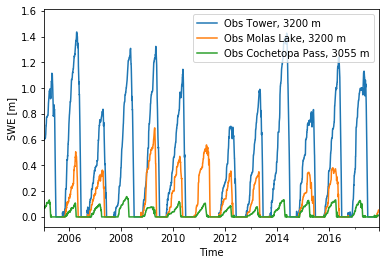

In [8]:
#plot SNOTELS: 
#ax = plt.gca()

ax = snotel_Tower.plot(kind='line',  y = 'SWE_m', label = 'Obs Tower, 3200 m')
snotel_Molas_Lake.plot(kind='line', y = 'SWE_m', label = 'Obs Molas Lake, 3200 m', ax = ax)
snotel_Cochetopa_Pass.plot(kind='line', y = 'SWE_m', label = 'Obs Cochetopa Pass, 3055 m', ax = ax)
ax.set_xlim([datetime(2005, 1, 21), datetime(2017, 12, 1)])
plt.xlabel('Time')
plt.ylabel('SWE [m]')

plt.show()

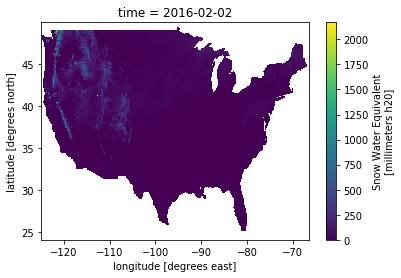

In [9]:
#UA Depth or SWE (choose variable)
%matplotlib inline 
DataArray = data_ua.SWE.sel(time = '2016-02-02') 
DataArray.plot()

In [10]:
#get OSSE domain
US2 = np.array([[-108.565, 40.715], [-105.025, 40.715], [-105.025, 37.525], [-108.565, 37.525]])


In [96]:
#regionmask.Regions([US2])

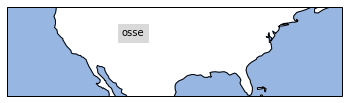

In [11]:
#plot OSSE Region 
names = ["osse_region"]
abbrevs = ["osse"]
osse_region = regionmask.Regions([US2], names=names, abbrevs=abbrevs, name="osse")
ax = osse_region.plot(label="abbrev")
ax.set_extent([225, 300, 25, 45], crs=ccrs.PlateCarree())


In [12]:
osse_region

1 'osse' Regions
osse

In [13]:
osse_poly = Polygon(US2)
OSSEregions_poly = regionmask.Regions([osse_poly])
OSSEregions_poly

1 'unnamed' Regions
r0

In [107]:
OSSEregions_poly

1 'unnamed' Regions
r0

In [14]:
mask_OSSE = OSSEregions_poly.mask(data_ua)

In [15]:
mask_OSSE1 = 

SyntaxError: invalid syntax (<ipython-input-15-877d093e8499>, line 1)

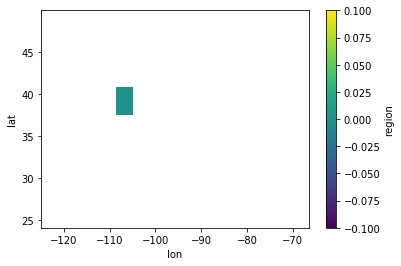

In [15]:
mask_OSSE.plot()


In [16]:
mask_OSSE.mean()

<xarray.DataArray 'region' ()>
array(0.)

In [17]:
mask_OSSE.to_netcdf("mask_OSSE.nc")

In [18]:
data_ua

<xarray.Dataset>
Dimensions:   (lat: 621, lon: 1405, time: 1826, time_str_len: 11)
Coordinates:
  * lat       (lat) float32 24.083334 24.125 24.166666 24.208334 24.25 ...
  * lon       (lon) float32 -125.0 -124.958336 -124.916664 -124.875 ...
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 2012-10-03 ...
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' ...
    time_str  (time_str_len, time) |S1 dask.array<shape=(11, 1826), chunksize=(11, 365)>
    SWE       (time, lat, lon) float32 dask.array<shape=(1826, 621, 1405), chunksize=(365, 621, 1405)>
    DEPTH     (time, lat, lon) float32 dask.array<shape=(1826, 621, 1405), chunksize=(365, 621, 1405)>

In [19]:
masked_data = data_ua.where(mask_OSSE == 0) #OSSE domanin
#masked_stats.mrro.plot()

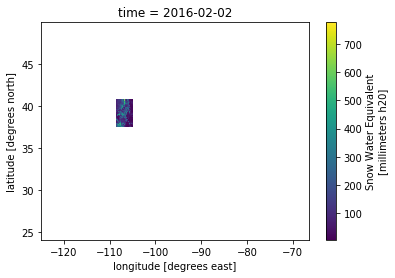

In [20]:
#ax = masked_data.SWE.sel(time = '2016-02-02').plot()

# fine tune the extent

#ax.set_extent([225, 300, 25, 45], crs=ccrs.PlateCarree())

masked_data.SWE.sel(time = '2016-02-02').plot()

In [23]:
sel_mask = mask_OSSE.where(mask_OSSE == 0).values
sel_mask
lat = mask_OSSE.lat.values
lon = mask_OSSE.lon.values
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

In [24]:
out_sel1 = data_ua.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], 
                                                                    id_lon[-1])).compute().where(mask_OSSE == 0)

In [25]:
out_sel1

<xarray.Dataset>
Dimensions:   (lat: 77, lon: 85, time: 1826, time_str_len: 11)
Coordinates:
  * lat       (lat) float64 37.54 37.58 37.62 37.67 37.71 37.75 37.79 37.83 ...
  * lon       (lon) float64 -108.5 -108.5 -108.5 -108.4 -108.4 -108.3 -108.3 ...
  * time      (time) datetime64[ns] 2012-10-01 2012-10-02 2012-10-03 ...
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time, lat, lon) object b'' b'' b'' b'' b'' b'' b'' b'' b'' ...
    time_str  (time_str_len, time, lat, lon) object b'0' b'0' b'0' b'0' b'0' ...
    SWE       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    DEPTH     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

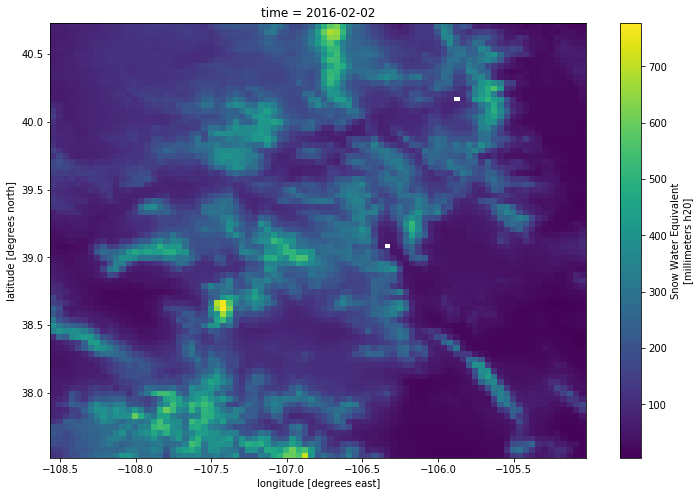

In [26]:
plt.figure(figsize=(12,8))
ax = plt.axes()
out_sel1.SWE.sel(time = '2016-02-02').plot()



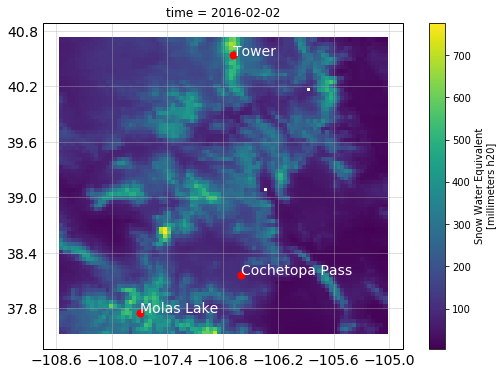

In [27]:
SWE_UA = out_sel1.SWE.sel(time = '2016-02-02')

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#ax.gridlines()
#SWE_UA.plot(ax=ax, transform=ccrs.PlateCarree(),
#         vmin=2, vmax=30, cbar_kwargs={'shrink': 0.4})

#SWE_UA.plot(ax=ax, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None
im = SWE_UA.plot(ax=ax)
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#t = ndvi.variable.data[0]

ax.plot(-107.6900, 37.7500, label = 'Molas Lake', color='red', marker='o', markersize = 7)
ax.text(-107.6900, 37.7500, 'Molas Lake', color = 'white', size = 14)

ax.plot(-106.6900, 40.5400, label = 'Tower', color='red', marker='o', markersize = 7)
ax.text(-106.6900, 40.5400, 'Tower', color = 'white', size = 14)

ax.plot(-106.6000, 38.1600, label = 'Cochetopa Pass', color='red', marker='o', markersize = 7)
ax.text(-106.6000, 38.1600, 'Cochetopa Pass', color = 'white', size = 14)

#SNODAS_molas_lake = ds_SNODAS['Band1'].sel(lat= 37.7500, lon = -107.6900, method = 'nearest')/1000
#SNODAS_tower = ds_SNODAS['Band1'].sel(lat = 40.5400, lon = -106.6900,  method = 'nearest')/1000
#SNODAS_cochetopa_pass = ds_SNODAS['Band1'].sel(lat = 38.1600, lon = -106.6000, method = 'nearest')/1000

plt.show()

In [28]:
 ds_SNODAS = xr.open_mfdataset(path_snodas +'*.nc' )
 #   ds_SNODAS = xr.open_mfdataset(files, concat_dim='time', autoclose=True)

In [30]:
SWE_SNODAS = ds_SNODAS.Band1.sel(time = '2016-02-02')

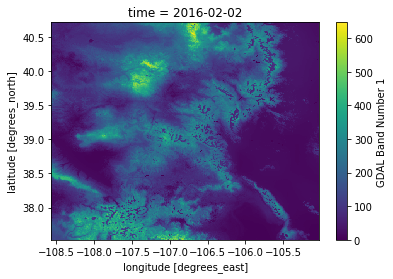

In [31]:
SWE_SNODAS.plot()

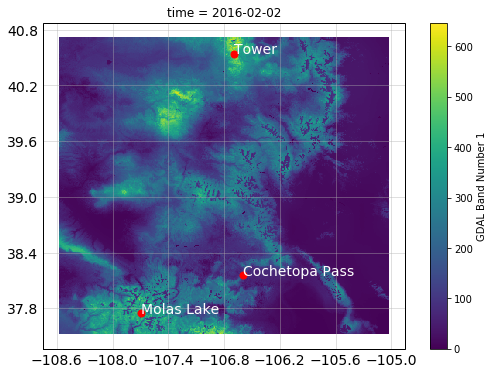

In [32]:
SWE_SNODAS = ds_SNODAS.Band1.sel(time = '2016-02-02')

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.coastlines()
#ax.gridlines()
#SWE_UA.plot(ax=ax, transform=ccrs.PlateCarree(),
#         vmin=2, vmax=30, cbar_kwargs={'shrink': 0.4})

#SWE_UA.plot(ax=ax, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None
im = SWE_SNODAS.plot(ax=ax)
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#t = ndvi.variable.data[0]

ax.plot(-107.6900, 37.7500, label = 'Molas Lake', color='red', marker='o', markersize = 7)
ax.text(-107.6900, 37.7500, 'Molas Lake', color = 'white', size = 14)

ax.plot(-106.6900, 40.5400, label = 'Tower', color='red', marker='o', markersize = 7)
ax.text(-106.6900, 40.5400, 'Tower', color = 'white', size = 14)

ax.plot(-106.6000, 38.1600, label = 'Cochetopa Pass', color='red', marker='o', markersize = 7)
ax.text(-106.6000, 38.1600, 'Cochetopa Pass', color = 'white', size = 14)

#SNODAS_molas_lake = ds_SNODAS['Band1'].sel(lat= 37.7500, lon = -107.6900, method = 'nearest')/1000
#SNODAS_tower = ds_SNODAS['Band1'].sel(lat = 40.5400, lon = -106.6900,  method = 'nearest')/1000
#SNODAS_cochetopa_pass = ds_SNODAS['Band1'].sel(lat = 38.1600, lon = -106.6000, method = 'nearest')/1000

plt.show()

In [33]:
ASO_50M_SD_USCOBR_20190419 = rioxarray.open_rasterio('/Users/carina/Desktop/data/seup/ASO_50m/ASO_50M_SD_USCOBR_20190419.tif')

#get projection data from a diffrent file 
ndvi = rioxarray.open_rasterio('/Users/carina/Desktop/data/Planet/climateEngine_download.NDVI.tif')



In [34]:
ASO_50M_SD_USCOBR_20190419 = ASO_50M_SD_USCOBR_20190419.rio.reproject(dst_crs = ndvi.rio.crs)


/Users/carina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


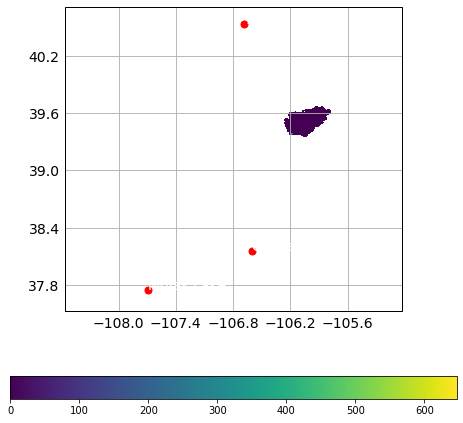

In [35]:
fig = plt.figure(figsize=(8,8))

central_lon, central_lat = -106.8, 39
#Lower left: 37.525 N, 108.565 W
#Upper right: 40.715 N, 105.025 W

extent = [-108.565, -105.025, 37.525, 40.715]

ax = plt.axes(projection = ccrs.PlateCarree())

ax.plot(-107.6900, 37.7500, label = 'Molas Lake', color='red', marker='o', markersize = 7)
ax.text(-107.6900, 37.7500, 'Molas Lake', color = 'white', size = 14)

ax.plot(-106.6900, 40.5400, label = 'Tower', color='red', marker='o', markersize = 7)
ax.text(-106.6900, 40.5400, 'Tower', color = 'white', size = 14)

ax.plot(-106.6000, 38.1600, label = 'Cochetopa Pass', color='red', marker='o', markersize = 7)
ax.text(-106.6000, 38.1600, 'Cochetopa Pass', color = 'white', size = 14)

lons_ASO_50M_SD_USCOBR_20190419 = ASO_50M_SD_USCOBR_20190419.x.values
lats_ASO_50M_SD_USCOBR_20190419 = ASO_50M_SD_USCOBR_20190419.y.values

vmin = 20
vmax = 30
plt.contourf(lons_ASO_50M_SD_USCOBR_20190419, lats_ASO_50M_SD_USCOBR_20190419, ASO_50M_SD_USCOBR_20190419.variable.data[0], vmin =vmin, vmax = vmax)

gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.xlabels_top = None
gl.ylabels_right = None

#im = ASO_50M_SD_USCOBR_20190419.plot(ax=ax)

gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}
#t = ndvi.variable.data[0]

cbar = fig.colorbar(im, ax=ax, orientation='horizontal') 
#plt.clim(0, 3)

cbar.set_clim(0, 0.4)

ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

In [36]:
path = '/Users/carina/Desktop/data/seup/ASO_50m/ASO_50M_SD_USCOBR_20190419.tif'
import ntpath

#ntpath.basename("a/b/c")
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail #or ntpath.basename(head)


def plot_ASO_lat_lon(path):
    aso = rioxarray.open_rasterio(path)
    aso = aso.rio.reproject(dst_crs = ndvi.rio.crs)
    fig = plt.figure(figsize=(8,8))

    central_lon, central_lat = -106.8, 39
    #Lower left: 37.525 N, 108.565 W
    #Upper right: 40.715 N, 105.025 W

    extent = [-108.565, -105.025, 37.525, 40.715]

    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.plot(-107.6900, 37.7500, label = 'Molas Lake', color='red', marker='o', markersize = 7)
    ax.text(-107.6900, 37.7500, 'Molas Lake', color = 'white', size = 14)

    ax.plot(-106.6900, 40.5400, label = 'Tower', color='red', marker='o', markersize = 7)
    ax.text(-106.6900, 40.5400, 'Tower', color = 'white', size = 14)

    ax.plot(-106.6000, 38.1600, label = 'Cochetopa Pass', color='red', marker='o', markersize = 7)
    ax.text(-106.6000, 38.1600, 'Cochetopa Pass', color = 'white', size = 14)

    lons_aso = aso.x.values
    lats_aso = aso.y.values

    vmin = 20
    vmax = 30
    plt.contourf(lons_aso, lats_aso, aso.variable.data[0], vmin =vmin, vmax = vmax)

    gl = ax.gridlines(draw_labels=True, alpha=0.5)
    gl.xlabels_top = None
    gl.ylabels_right = None

    #im = ASO_50M_SD_USCOBR_20190419.plot(ax=ax)

    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    #t = ndvi.variable.data[0]

    
    #cbar = fig.colorbar(im, ax=ax, orientation='horizontal') 
    #plt.clim(0, 3)
    
    #cbar.set_clim(0, 0.4)

    ax.set_extent(extent)
    ax.gridlines()
    title = path_leaf(path)
    #ax.set_title = title
    ax.set_title(title)
    ax.coastlines(resolution='50m')
    return 
    
    

    
    

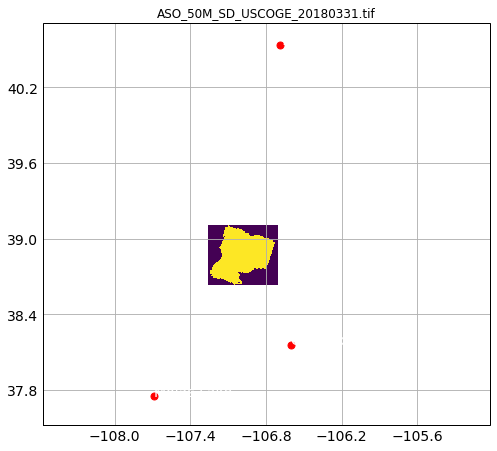

In [37]:
plot_ASO_lat_lon('/Users/carina/Desktop/data/seup/ASO_50m/ASO_50M_SD_USCOGE_20180331.tif')

In [38]:
import ntpath
#ntpath.basename("a/b/c")
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail #or ntpath.basename(head)

In [39]:
path_leaf('/Users/carina/Desktop/data/seup/ASO_50m/ASO_50M_SD_USCOGE_20180331.tif')

'ASO_50M_SD_USCOGE_20180331.tif'

In [40]:
import glob
list_file = []
for name in glob.glob('/Users/carina/Desktop/data/seup/ASO_50m/*.tif'):
    list_file.append(name)
#list_file    

In [48]:
#plot all ASO files 
#for file in list_file:
#    plot_ASO_lat_lon(file)

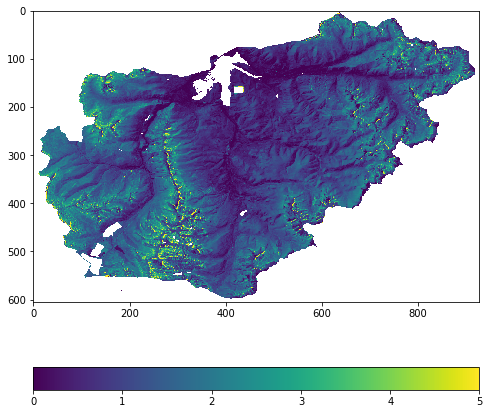

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(ASO_50M_SD_USCOBR_20190419.variable.data[0])
fig.colorbar(im, ax=ax, orientation='horizontal')

im.set_clim(0, 5)

#cbar.set_clim(0, 2.0)

plt.show()

#plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
#plt.colorbar()
#plt.clim(-1, 1);

In [67]:
#ASO_50M_SD_USCOBR_20190419.plot.variable.data[0]

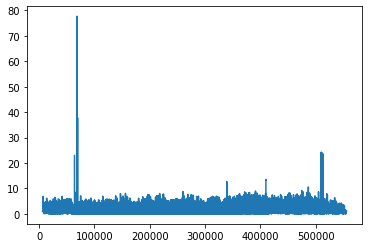

In [45]:
test = test.flatten()
#plt.hist(test, bins = 25)
plt.plot(test)

In [44]:
test = ASO_50M_SD_USCOBR_20190419.variable.data[0]


In [41]:
ASO_50M_SD_USCOBR_20190419

<xarray.DataArray (band: 1, y: 606, x: 928)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -106.3 -106.3 -106.3 -106.3 -106.3 -106.3 ...
  * y            (y) float64 39.68 39.68 39.67 39.67 39.67 39.67 39.67 39.67 ...
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    transform:     (0.000532740954512495, 0.0, -106.26524901145606, 0.0, -0.0...
    _FillValue:    nan
    grid_mapping:  spatial_ref

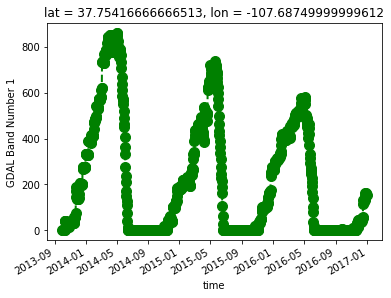

In [42]:
#ta = ds_SNODAS['Band1']
#plot SNODAS 
ta_CBR = ds_SNODAS['Band1'].sel(lat= 37.7500, lon = -107.6900, method = 'nearest')
ta_CBR.sel(time = slice('2013-10-01','2018-10-01')).plot(linestyle='dashed',color='g', 
                                                         linewidth=2, marker='o',markersize=10)

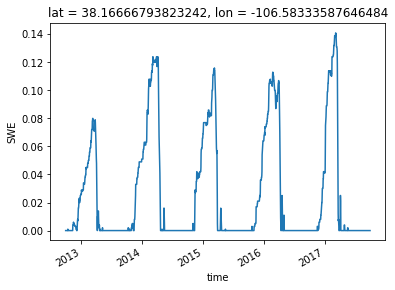

In [43]:
ua_molas_lake = out_sel1.sel(lat = 37.7500, lon = -107.6900,  method='nearest')
ua_tower = out_sel1.sel(lat = 40.5400, lon = -106.6900,  method='nearest')
ua_cochetopa_pass = out_sel1.sel(lat = 38.1600, lon = -106.6000,  method='nearest')

SNODAS_molas_lake = ds_SNODAS['Band1'].sel(lat= 37.7500, lon = -107.6900, method = 'nearest')/1000
SNODAS_tower = ds_SNODAS['Band1'].sel(lat = 40.5400, lon = -106.6900,  method = 'nearest')/1000
SNODAS_cochetopa_pass = ds_SNODAS['Band1'].sel(lat = 38.1600, lon = -106.6000, method = 'nearest')/1000


#ua_molas_lake.SWE = ua_molas_lake.SWE / 1000
ua_tower['SWE'] = ua_tower['SWE']/1000
ua_molas_lake['SWE'] = ua_molas_lake['SWE']/1000
ua_cochetopa_pass['SWE'] = ua_cochetopa_pass['SWE']/1000

ua_cochetopa_pass.SWE.plot()

In [44]:
#convert to pandas
ua_molas_lake_SWE= ua_molas_lake.SWE.to_pandas()
ua_tower_SWE = ua_tower.SWE.to_pandas()
ua_cochetopa_pass_SWE = ua_cochetopa_pass.SWE.to_pandas()

SNODAS_molas_lake_SWE = SNODAS_molas_lake.to_pandas()
SNODAS_tower_SWE = SNODAS_tower.to_pandas()
SNODAS_cochetopa_pass_SWE = SNODAS_cochetopa_pass.to_pandas()

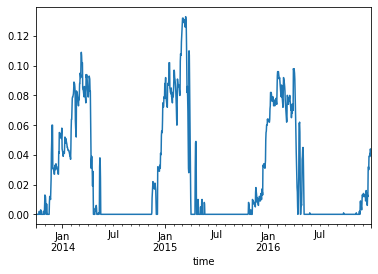

In [45]:
SNODAS_cochetopa_pass_SWE.plot()

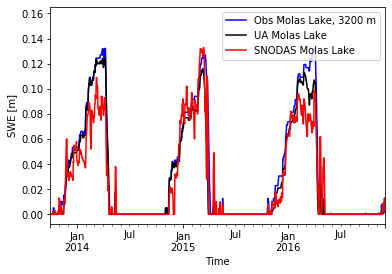

In [46]:
plt.figure(1)
#ax1 = snotel_Tower.plot(kind='line', ax = plt.gca(), y = 'SWE_m', color = 'blue', label = 'Obs Tower, 3200 m')

#ax1 = snotel_Molas_Lake.plot(kind='line', ax = plt.gca(), y = 'SWE_m', color = 'blue', label = 'Obs Molas Lake, 3200 m')

ax1 = snotel_Cochetopa_Pass.plot(kind='line', ax = plt.gca(), y = 'SWE_m', color = 'blue', label = 'Obs Molas Lake, 3200 m')


#ua_tower_SWE.plot(kind='line', y = 'SWE', ax = ax1, color = 'black', label = 'UA Tower', legend = True)
#SNODAS_tower_SWE.plot(kind='line', ax = ax1, color = 'red', label = 'SNODAS Tower', legend = True)

#ua_molas_lake_SWE.plot(kind='line', y = 'SWE', ax = ax1, color = 'black', label = 'UA Molas Lake', legend = True)
#SNODAS_molas_lake_SWE.plot(kind='line', ax = ax1, color = 'red', label = 'SNODAS Molas Lake', legend = True)

ua_cochetopa_pass_SWE.plot(kind='line', y = 'SWE', ax = ax1, color = 'black', label = 'UA Molas Lake', legend = True)
SNODAS_cochetopa_pass_SWE.plot(kind='line', ax = ax1, color = 'red', label = 'SNODAS Molas Lake', legend = True)


ax1.set_xlim([datetime(2013, 10, 1), datetime(2016, 12, 1)])
plt.xlabel('Time')
plt.ylabel('SWE [m]')

plt.show()

(0, 0.3)

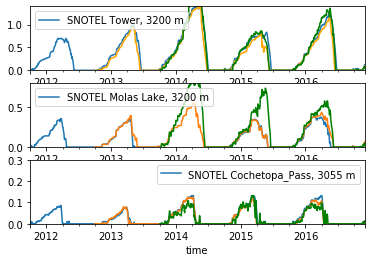

In [47]:
plt.figure(2)
plt.subplot(3,1,1)
ax1 = snotel_Tower.plot(kind='line',  y = 'SWE_m', label = 'SNOTEL Tower, 3200 m',  ax=plt.gca())
ua_tower_SWE.plot(kind='line', y = 'SWE',  ax = ax1, color = 'orange', label = 'UA Tower')
SNODAS_tower_SWE.plot(kind='line',  ax = ax1, color = 'green', label = 'SNODAS Tower')

ax1.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)])
#plt.xlabel('Time')
#plt.ylabel('SWE [m]')

plt.subplot(3,1,2)
ax2 = snotel_Molas_Lake.plot(kind='line',  y = 'SWE_m', label = 'SNOTEL Molas Lake, 3200 m', ax=plt.gca())
ua_molas_lake_SWE.plot(kind='line', y = 'SWE', label = 'UA Tower', ax = ax2)
SNODAS_molas_lake_SWE.plot(kind='line', y = 'Band1',  ax = ax2, color = 'green', label = 'SNODAS Tower')

ax2.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)])
#plt.xlabel('Time')
#plt.ylabel('SWE [m]')

plt.subplot(3,1,3)
ax3 = snotel_Cochetopa_Pass.plot(kind='line',  y = 'SWE_m', label = 'SNOTEL Cochetopa_Pass, 3055 m', ax=plt.gca())
ua_cochetopa_pass_SWE.plot(kind='line', y = 'SWE', label = 'UA Tower', ax = ax3)
SNODAS_cochetopa_pass_SWE.plot(kind='line', y = 'Band1',  ax = ax3, color = 'green', label = 'SNODAS Tower')

ax3.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)])
#plt.xlabel('Time')
#plt.ylabel('SWE [m]')

ax1.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)])
ax2.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)]) 
ax3.set_xlim([datetime(2011, 10, 1), datetime(2016, 12, 1)])

ax1.set_ylim([0, 1.4]) 
ax2.set_ylim([0, 0.8]) 
ax3.set_ylim([0, 0.3]) 

In [ ]:
                                                  linewidth=2, marker='o',markersize=10)

In [ ]:
SNODAS_tower_SWE

In [ ]:
SNODAS_tower